In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import altair as alt
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

In [2]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')

In [3]:
from load_gridcell_areas import *

In [4]:
whitakker_map=xr.open_dataset('whitakker_map.nc')

In [5]:
def calculate_whitakker_landweights(biome_num=2, domain='atm'):
    singlebiome=((whitakker_map.BCLASS==biome_num))
    singlebiome_landarea=(singlebiome*landarea)
    singlebiome_landweights=singlebiome_landarea/singlebiome_landarea.sum()
    if domain=='atm':
        singlebiome_landweights=singlebiome_landweights.reindex_like(ds_h0, method='nearest', tolerance=0.05)
    return singlebiome_landweights

# Load Data

In [6]:
from load_ensembles import *

In [7]:
var='TS'
h='h0'

basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/atm/proc/tseries/COUP0000_PI_SOM.cam.'+h+'.timeseries.'+var+'.nc')

ref=basecase_lnd[var][12*60:,:,:].mean(dim='time')
ref_tseries=basecase_lnd[var][12*60:,:,:].groupby('time.year').mean(dim='time')

ensemble_coupled=load_coupled_ensemble(var=var, domain='atm')

/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/ncar/usr/jupyterhub/envs/pangeo-2019.09.12/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [8]:
weights.sum()

NameError: name 'weights' is not defined

# Do whitakker analysis

In [9]:
labels=['Ice Sheet',
        'Tropical rain forest',
 'Tropical seasonal forest/savanna',
 'Subtropical desert',
 'Temperate rain forest',
 'Temperate seasonal forest',
 'Woodland/shrubland',
 'Temperate grassland/desert',
 'Boreal forest',
 'Tundra',
 'Ice sheet']

In [10]:
for biome_num in np.arange(0,9):
    print(biome_num)
    whitakker_landweights=calculate_whitakker_landweights(biome_num=biome_num)
    weights=whitakker_landweights

    ref_comparison = (ref*weights).sum(dim=['lat','lon']).values-273.15
    global_temps=[]
    for i, ds in enumerate(ensemble_coupled):
        #print(i)
        annual_avg=ds[var][12*60:,:,:].mean(dim='time')-273.15
        global_mean = (annual_avg*weights).sum(dim=['lat','lon']).values
        global_temps.append(global_mean-ref_comparison)
        
    crosswalk[labels[biome_num]]=global_temps

0
1
2
3
4
5
6
7
8


In [11]:
crosswalk_flat = pd.melt(crosswalk, ['key_CLM5PPE', 'param', 'minmax', 'include', 'parameter domain',
       'parameter category', 'parameter description', 'key_coupledPPE',
       'key_landonlyPPE', 'notes', 'Key_short', 'description'])

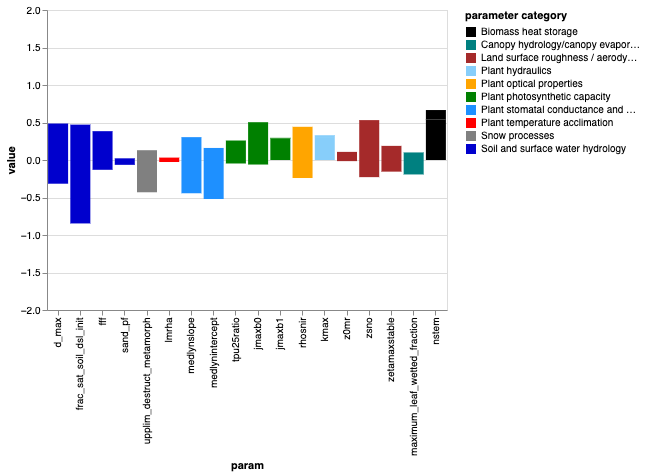

In [12]:
colors = ['black','teal','brown','lightskyblue','orange','green','dodgerblue','red',
         'grey','mediumblue']

select_box = alt.binding_select(options=list(crosswalk_flat['variable'].unique()))
selection = alt.selection_single(name='y_axis', fields=['variable'], bind=select_box, init={'variable':'Ice Sheet'})

#manual_ordered = manual_ordered.sort_values(['col', 'index'], ascending=[False, True])
source = crosswalk_flat
points=alt.Chart(source).mark_bar(filled=True).encode(
    x=alt.X('param', sort=alt.SortField(field="parameter category",
                                        order='descending')),#, scale=alt.Scale(domain=[minval, maxval])),
    y=alt.Y('value',scale=alt.Scale(domain=[-2, 2])),
    #opacity='parameter domain',
    color=alt.Color('parameter category', scale=alt.Scale(range=colors)),
    #opacity='minmax',
    tooltip=['param', 
             'parameter description',
             'parameter domain', 
             'parameter category', 
             #'global_nonglacland_temp'
             'minmax']
).add_selection(
    selection
).transform_filter(
    selection
)#.interactive()

points
#plt.savefig('altairchart.png')

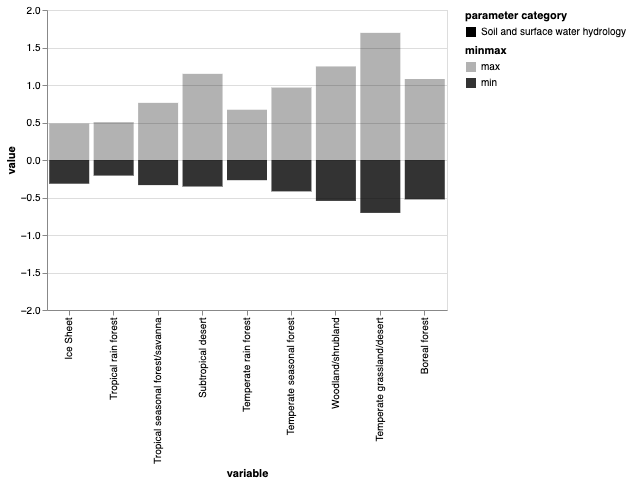

In [14]:
colors = ['black','teal','brown','lightskyblue','orange','green','dodgerblue','red',
         'grey','mediumblue']

select_box = alt.binding_select(options=list(crosswalk_flat['param'].unique()))
selection = alt.selection_single(name='parameter', fields=['param'], bind=select_box, init={'param':'d_max'})

#manual_ordered = manual_ordered.sort_values(['col', 'index'], ascending=[False, True])
source = crosswalk_flat
points=alt.Chart(source).mark_bar(filled=True).encode(
    x=alt.X('variable', sort=labels),#, scale=alt.Scale(domain=[minval, maxval])),
    y=alt.Y('value',scale=alt.Scale(domain=[-2, 2])),
    #opacity='parameter domain',
    color=alt.Color('parameter category', scale=alt.Scale(range=colors)),
    opacity='minmax',
    tooltip=['param', 
             'parameter description',
             'parameter domain', 
             'parameter category', 
             #'global_nonglacland_temp'
             'minmax']
).add_selection(
    selection
).transform_filter(
    selection
)#.interactive()

points
#plt.savefig('altairchart.png')